In [400]:
import pandas as pd

records = pd.read_csv('train.csv')

expert_consensus
Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: count, dtype: int64

In [405]:
# records['expert_consensus'].value_counts()
records.groupby('spectrogram_id').sample(n=3, replace=True).expert_consensus.value_counts()


expert_consensus
Other      13836
Seizure     6101
GRDA        4295
LPD         3915
GPD         3157
LRDA        2110
Name: count, dtype: int64

In [447]:
df = records[records.spectrogram_id.isin([999431, 353733, 2147388374, 2147312808])]
df = df.groupby(['spectrogram_id', 'expert_consensus']).sample(
    n=1,
    replace=True,
)

df
# records

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
6       1628180742           6                      30.0          353733   
20       722738444           9                      22.0          999431   
106786  1306668185           2                       4.0      2147312808   
106789   351917269           0                       0.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
6                        6                              30.0   364593930   
20                       9                              22.0  4101058765   
106786                   2                               4.0   230575779   
106789                   0                               0.0   429140316   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
6            42516          Seizure             3         0         0   
20           56885             LRDA             0         1         0   
106786       57480              LPD             0         3         0   
106789       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
6               0          0           0  
20             14          0           1  
106786          0          0           0  
106789          3          0           0

In [643]:
import pandas as pd

# NAMES = ['LL','LP','RP','RR']
# FEATS = [['Fp1','F7','T3','T5','O1'],
#          ['Fp1','F3','C3','P3','O1'],
#          ['Fp2','F8','T4','T6','O2'],
#          ['Fp2','F4','C4','P4','O2']]

NAMES = ['L', 'R']
FEATS = [['Fp1','F7','T3','T5','O1','F3','C3','P3'],
         ['Fp2','F8','T4','T6','O2', 'F4','C4','P4']]

data = pd.read_parquet('eeg/seizures/1083464967.parquet')
data[FEATS[0]].shape

(27600, 8)

In [620]:
import pandas as pd

train_data_df = pd.read_csv('train.csv')

train_data_df.expert_consensus.unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

In [634]:
def get_consensus_eeg_paths(data_df, category):
    eeg_ids = data_df[data_df.expert_consensus == category].eeg_id.unique().astype('str')
    eeg_ids.sort()

    return list(map(lambda p: f'{p}.parquet', eeg_ids))

get_consensus_eeg_paths(train_data_df, 'GPD')[:5]
# consensus_df = train_data_df.groupby('expert_consensus').sample(n=5)[['eeg_id', 'expert_consensus']]
# # seizure_df = get_consensus_data(train_data_df, 'Seizure')

# # seizure_df.eeg_id.unique().astype('str').sort()
# consensus_df

['1001487592.parquet',
 '1002136740.parquet',
 '1002142157.parquet',
 '1004534549.parquet',
 '1010760130.parquet']

In [125]:
import albumentations as A

def noop(x, **kwargs): return x

noop_transform = A.Compose([
    A.Lambda(image=noop, mask=noop)
])

In [1073]:
import functools

import pandas as pd

@functools.cache
def load_parquet(file_path):
    return pd.read_parquet(file_path).fillna(0)

def load_eeg(file_path, columns=None):
    data = load_parquet(file_path)
    data = data[columns] if columns else data
    return data.values

def load_spectrogram(file_path):
    return load_parquet(file_path).values

def get_data_fns(config):
    print(f'\n Data Column: {config.data_column}\n')

    if config.data_column == 'eeg_id':
        load_fn = functools.partial(load_eeg, columns=config.eeg_columns)
        offset_fn = lambda x: int(x*200)
    else:
        load_fn = load_spectrogram
        offset_fn = lambda x: x//2
    
    return load_fn, offset_fn

In [561]:
class Props(dict):
    def __init__(self, *args, **kwargs):
        super(Props, self).__init__(*args, **kwargs)
        self.__dict__ = self
    
    def __getattribute__(self, name):
        try:
            return super(Props, self).__getattribute__(name)
        except AttributeError:
            return None

model_config = Props(x=2)
model_config.x, model_config.y

(2, None)

In [60]:
import pandas as pd
import numpy as np

from functools import reduce
from pathlib import Path

config = Props(
    root=Path('.'),
    classes=['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other'],
)
label_to_index = {name:idx for idx, name in enumerate(config.classes)}
vote_columns =  np.char.add(np.char.lower(config.classes), '_vote')

def load_data(config, name, randomize=False):
    def to_pct_votes(group_df, target_cols):
        # 2. Compute vote percentage per target per eeg.
        target_votes = group_df[target_cols].agg('sum')
        total_votes = target_votes.sum(axis=1)
        pct_votes = target_votes.values / np.expand_dims(total_votes.values, -1)
        
        return pct_votes
    
    def groupby_eeg_id(df):
        """
        1. Group by eeg_id to get one entry per eeg_id.
        2. Transform votes per eeg_id to percentages.
        3. Create a column for expert_consensus.
        """
        # 1. Group EEG by eeg_id to get unique values per eeg_id.
        group_df = df.groupby('eeg_id')
        
        # 2. Compute vote percentages.
        pct_votes = to_pct_votes(group_df, vote_columns)
        
        # X. Compose results
        df = group_df.agg('first')
        df[vote_columns] = pct_votes
        df['label'] = df.expert_consensus.apply(lambda l: label_to_index[l])

        return df

    # 1. Load csv.
    df = pd.read_csv(config.root / f'{name}.csv')
    
    # 2. Setup EEG and spectrogram paths.
    df['eeg_path'] = config.root / f'{name}_eegs' / (df.eeg_id.astype(str) + '.parquet')
    df['spec_path'] = config.root / f'{name}_spectrograms' / (df.spectrogram_id.astype(str) + '.parquet')
    
    # 3. Convert votes to percentages.
    if df.columns.isin(['expert_consensus']).any():
        df = groupby_eeg_id(df)
    
    print(
        f'\nData: {name.capitalize()}'
        f'\nSize: {len(df)=}'
    )
    
    return df.sample(frac=1.0).reset_index(drop=True) if randomize else df

train_data_df = load_data(
    config,
    'train',
    randomize=True,
)

print(
    f'{len(train_data_df)=}'
)

display(train_data_df.head(2))


Data: Train
Size: len(df)=17089
len(train_data_df)=17089


eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  spectrogram_sub_id  \
0           0                       0.0      1756758120                   0   
1           0                       0.0      2077600099                   9   

   spectrogram_label_offset_seconds    label_id  patient_id expert_consensus  \
0                               0.0  1584969542       21950              GPD   
1                             898.0  2876683622       41114          Seizure   

   seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote  \
0      0.105263       0.0  0.473684        0.0   0.105263    0.315789   
1      0.500000       0.5  0.000000        0.0   0.000000    0.000000   

                        eeg_path                              spec_path  label  
0    train_eegs/41811879.parquet  train_spectrograms/1756758120.parquet      2  
1  train_eegs/1860165106.parquet  train_spectrograms/2077600099.parquet      0

In [4]:
import itertools

from pathlib import Path

categories = ['gpd', 'seizures']

eeg_paths = list(itertools.chain(*map(
    lambda c: (Path('./eeg/') / c).glob('**/*.parquet'),
    categories
)))

In [1856]:
import pandas as pd

result_files = Path('./results/').glob('*.csv')
results = dict(map(
    lambda f: (f.stem, pd.read_csv(f)),
    result_files
))

comparison_df = pd.merge(*list(results.values()), on=['eeg_id', 'expert_consensus', 'label'])
comparison_df

eeg_id expert_consensus  label  predicted_label_x  seizure_vote_x  \
0         582999              LPD      1                  5        0.071132   
1         642382            Other      5                  5        0.002899   
2        1895581            Other      5                  5        0.111488   
3        2061593            Other      5                  5        0.021297   
4        2366870            Other      5                  5        0.016859   
...          ...              ...    ...                ...             ...   
6831  4291744526             GRDA      4                  4        0.047777   
6832  4292843598          Seizure      0                  0        0.947294   
6833  4293306306              GPD      2                  2        0.005101   
6834  4294455489            Other      5                  5        0.115715   
6835  4294958358            Other      5                  5        0.094418   

      lpd_vote_x  gpd_vote_x  lrda_vote_x  grda_vote_x  other_vote_x  \
0       0.175493    0.003057     0.100566     0.024653      0.625098   
1       0.001830    0.002193     0.016563     0.140841      0.835675   
2       0.004720    0.001577     0.033140     0.052297      0.796778   
3       0.015350    0.002809     0.074460     0.096197      0.789887   
4       0.326723    0.027787     0.061675     0.041684      0.525273   
...          ...         ...          ...          ...           ...   
6831    0.008553    0.021695     0.070565     0.514471      0.336938   
6832    0.011255    0.004922     0.008850     0.007667      0.020012   
6833    0.083342    0.389234     0.031941     0.193516      0.296867   
6834    0.155394    0.084986     0.039625     0.059670      0.544610   
6835    0.029188    0.005596     0.036105     0.039000      0.795693   

      predicted_label_y  seizure_vote_y  lpd_vote_y  gpd_vote_y  lrda_vote_y  \
0                     5        0.015711    0.219306    0.006847     0.119095   
1                     5        0.011544    0.013754    0.003004     0.016665   
2                     5        0.334121    0.057982    0.002914     0.088470   
3                     5        0.010148    0.008541    0.001606     0.022278   
4                     5        0.009122    0.075107    0.009583     0.025276   
...                 ...             ...         ...         ...          ...   
6831                  5        0.018623    0.025112    0.012063     0.112252   
6832                  0        0.752309    0.160758    0.046161     0.006262   
6833                  4        0.012849    0.066538    0.126927     0.080523   
6834                  5        0.114047    0.036133    0.006121     0.044808   
6835                  5        0.038694    0.095974    0.005708     0.082139   

      grda_vote_y  other_vote_y  
0        0.045220      0.593820  
1        0.033073      0.921961  
2        0.042535      0.473979  
3        0.048106      0.909321  
4        0.027369      0.853543  
...           ...           ...  
6831     0.376985      0.454965  
6832     0.002507      0.032003  
6833     0.397965      0.315198  
6834     0.048674      0.750216  
6835     0.050517      0.726969  

[6836 rows x 17 columns]

In [1857]:
both_correct_df = comparison_df[(comparison_df['label'] == comparison_df['predicted_label_x']) & (comparison_df['label'] == comparison_df['predicted_label_y'])]

(len(both_correct_df) / len(comparison_df))*100

60.12287887653599

In [1858]:
one_correct_df = comparison_df[(comparison_df['label'] == comparison_df['predicted_label_x']) | (comparison_df['label'] == comparison_df['predicted_label_y'])]

(len(one_correct_df) / len(comparison_df))*100

77.61849034523112

In [1859]:
for cat, result in results.items():
    correct_df = result[(result['label'] == result['predicted_label'])]
    print(
        f'\n{cat}: {len(correct_df)/len(result):.2%}'
    )

    category_df = correct_df.groupby('expert_consensus').agg({'label': 'count'})

    print(f'{category_df} {category_df["label"].sum()}')


valid.predictions.128: 67.25%
                  label
expert_consensus       
GPD                 534
GRDA                407
LPD                 628
LRDA                101
Other              2414
Seizure             513 4597

valid.predictions.256: 70.49%
                  label
expert_consensus       
GPD                 543
GRDA                396
LPD                 617
LRDA                 35
Other              2540
Seizure             688 4819


In [1864]:
combined_df = pd.concat(results.values()).groupby(
    ['eeg_id', 'expert_consensus', 'label']
 )[vote_columns].agg('mean').reset_index()

combined_df['predicted_label'] = combined_df[vote_columns].idxmax(axis=1).apply(lambda v: label_to_index[v.split('_')[0]])

# combined_results
len(combined_df[combined_df['label'] == combined_df['predicted_label']]) / len(combined_df)

0.7084552369806905

In [242]:
label_to_index = {name.lower():idx for idx, name in enumerate(config.classes)}

In [252]:
# df = results['valid.predictions.efficientnet']
df = results['valid.predictions.efficientnet']
len(df[df['label'] == df['predicted_label']]) / len(df)

0.6601813926272674

In [114]:
import numpy as np

from pathlib import Path

cache_root = Path('eeg_cache')

eeg_cache_items = [p for p in cache_root.glob('*.npy')]

[PosixPath('eeg_cache/1000913311.npy'),
 PosixPath('eeg_cache/1003675786.npy'),
 PosixPath('eeg_cache/1018200965.npy'),
 PosixPath('eeg_cache/1007356722.npy')]

In [992]:
import itertools

import numpy as np

from matplotlib import pyplot as plt

BLANK_STR_FN = lambda *x:''

def make_grid_plot(num_items, cols=3, size=3, **kwargs):
    # Compute rows and columns
    num_items = num_items or 1
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    # Create axes
    fig, axes = plt.subplots(
        rows, cols,
        figsize=np.array([cols, rows])*size,
        **kwargs,
    )

    # Flatten axes for easy iteration
    axes = axes.flatten() if num_items > 1 else [axes]
    
    return fig, axes[:num_items]

def show_items(
    items, load_fn=lambda x:x,
    title_fn=BLANK_STR_FN, column_fn=BLANK_STR_FN,
    transforms={},
    cols=1, size=2, plot='plot'
):
    def show_fn(item_idx, axes):
        # 1. Get item and data
        item = items[item_idx]
        data = load_fn(item)

        # 2. Compose label and title
        ylabel = column_fn(item_idx, item, data)

        # 3. Plot item
        getattr(axes[0], plot)(data)
        axes[0].set_title(title_fn(item_idx, item, data))
        axes[0].set_ylabel(ylabel)

        # 4. Plot transforms
        for ax, (name, fn) in zip(axes[1:], transforms.items()):
            transformed_data = fn(data)
            ax.plot(transformed_data)
            ax.set_title(f'{name}: {title_fn(item_idx, item, transformed_data)}')
            ax.set_ylabel(ylabel)

    # 1. Compute plots per item (item + transforms) and the total number of plots
    group_size = 1 + len(transforms)
    plot_count = len(items)*group_size

    # 2. Create plot
    fig, axes = make_grid_plot(
        plot_count,
        cols=cols, size=size, gridspec_kw={'hspace': .5}
    )

    # 3. Iterate over the items.
    for idx in range(len(items)):
        start, end = idx*group_size, (idx + 1)*group_size
        show_fn(idx, axes[start:end])

    return fig

eeg/seizures/1001717358.parquet


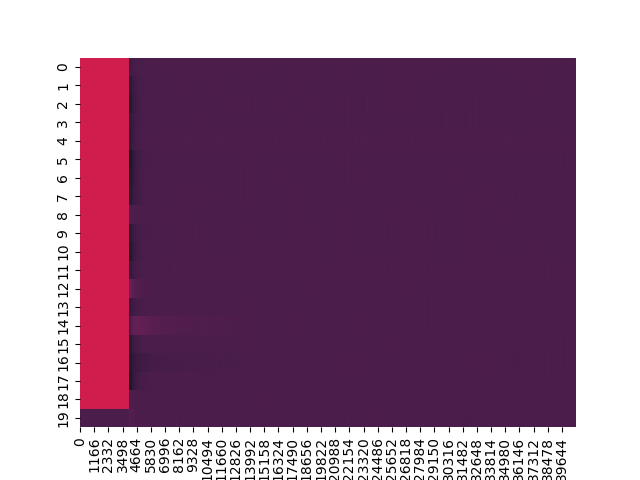

(1020, 20)


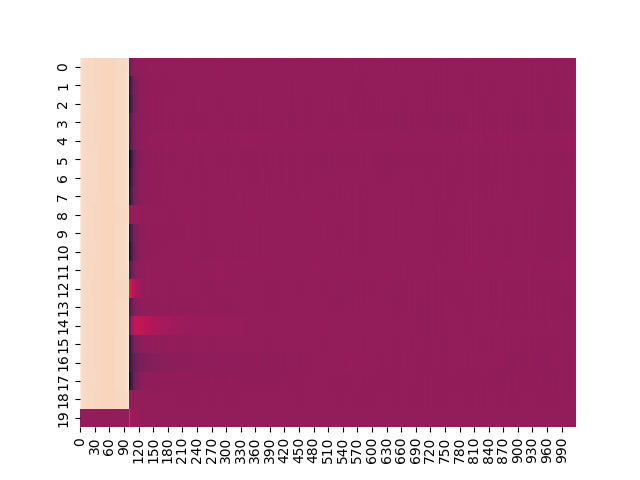

(2040, 20)


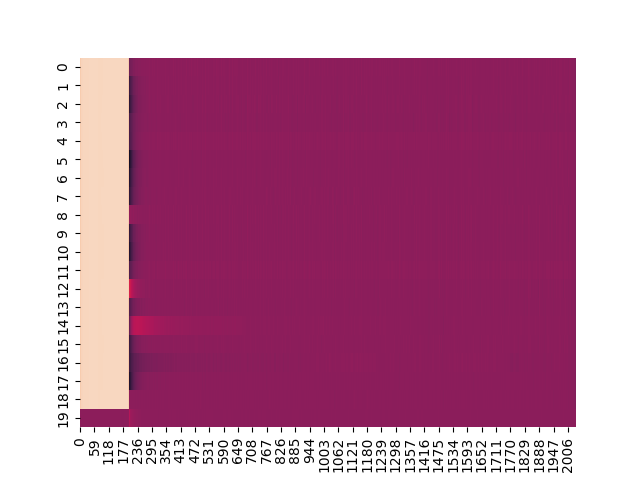

(4080, 20)


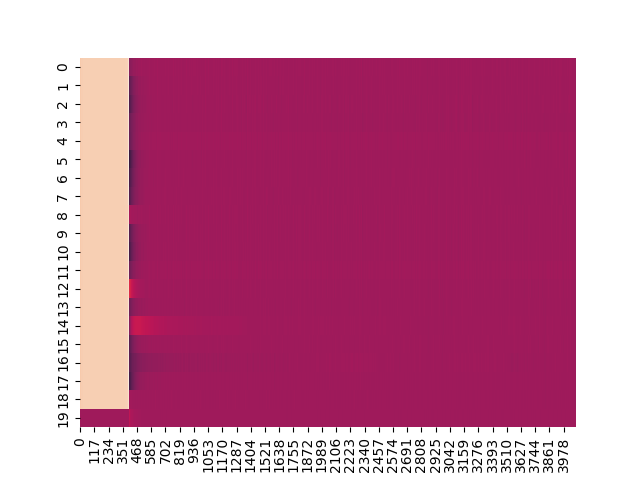

eeg/seizures/1006509151.parquet


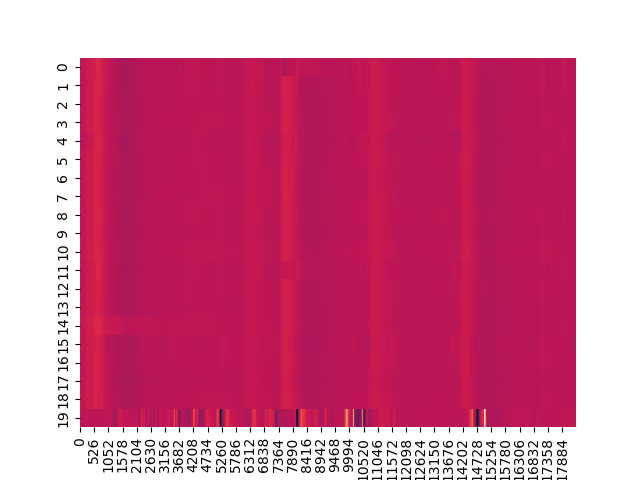

(460, 20)


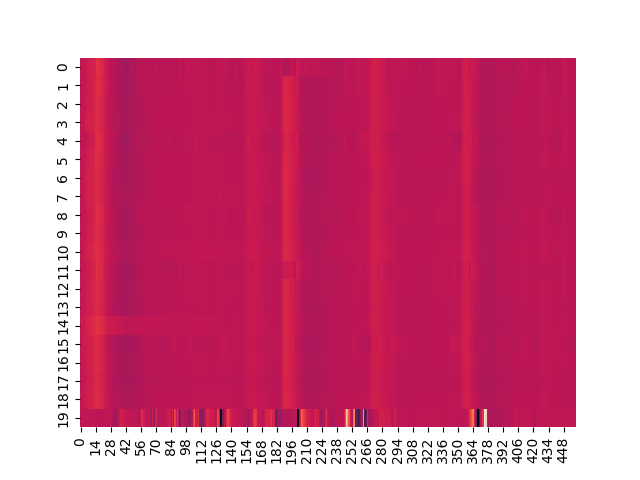

(920, 20)


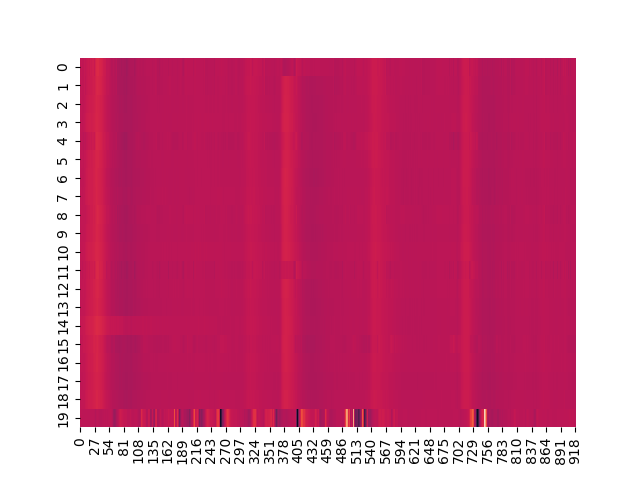

(1840, 20)


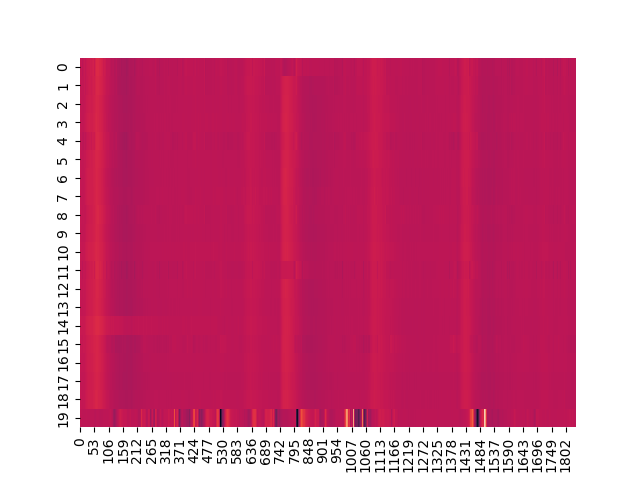

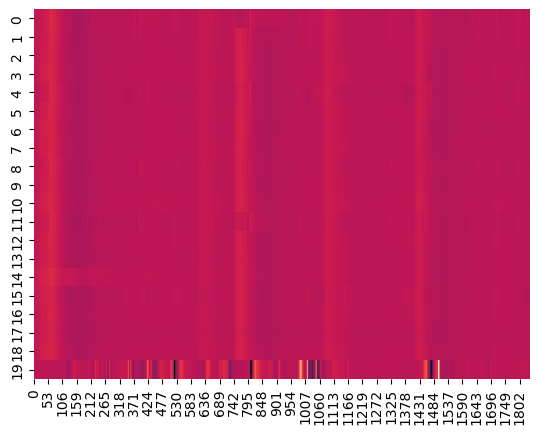

In [985]:
import io

import seaborn as sns

from PIL import Image
from scipy import signal

def image_from_ax(ax):
    fig = ax.get_figure()
    fig.canvas.draw()
    im = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    return im

def eeg_to_image(eeg):
    ax = sns.heatmap(eeg.T, cbar=False)
    image = image_from_ax(ax)
    return image

def resample_fn(data, targets=[5, 10, 20], base=200):
    target_sizes = list(map(
        lambda f: (data.shape[0] // base)*f,
        targets # Resampling frequencies
    ))
    resampled_items = list(map(
        lambda s: signal.resample(data, s),
        target_sizes
    ))
    return resampled_items

items = []

for p in eeg_paths[5:7]:
    eeg = load_eeg(p)
    print(p)

    # Append original EEG
    im = eeg_to_image(eeg)
    items.append(np.array(im))
    display(im)

    resampled_items = resample_fn(eeg)
    for item in resampled_items:
        print(item.shape)
        im = eeg_to_image(item)
        items.append(np.array(im))
        display(im)


In [986]:
eeg = load_eeg(eeg_paths[0])

In [1008]:
import pandas as pd

df = pd.DataFrame([[.2, 0., .3]], columns=['v1', 'v2', 'v3'])

(df[['v1', 'v2', 'v3']].values > 0).astype('float32')

array([[1., 0., 1.]], dtype=float32)

In [1029]:
import functools
import itertools

from collections import OrderedDict

def load_parquet(file_path):
    return pd.read_parquet(file_path).fillna(0)

def eeg_loader(config):
    groups = config.eeg_signal.groups
    
    @functools.cache
    def fn(file_path):
        data = load_parquet(file_path)
        eeg = np.zeros((len(data), len(groups), 4))
        for idx, (name, cols) in enumerate(groups.items()):
            eeg[:, idx, :] = data[cols[0]].values - data[cols[1]].values

        return eeg.reshape((len(data), -1))
    
    return fn

config = Props(
    eeg_signal=Props(
        groups=OrderedDict(
            LL=(['Fp1','F7','T3','T5'], ['F7','T3','T5','O1']),
            LP=(['Fp1','F3','C3','P3'], ['F3','C3','P3','O1']),
            RL=(['Fp2','F8','T4','T6'], ['F8','T4','T6','O2']),
            RP=(['Fp2','F4','C4','P4'], ['F4','C4','P4','O2']),
        )
    )
)

load_fn = eeg_loader(config)
load_fn(eeg_paths[0]).shape



(18000, 16)

In [1250]:
def eeg_loader(config):
    groups = config.eeg_signal.groups
    
    @functools.cache
    def fn(file_path):
        data = load_parquet(file_path)
        eeg = np.zeros((len(data), len(groups), 4))
        for idx, (name, cols) in enumerate(groups.items()):
            eeg[:, idx, :] = data[cols[0]].values - data[cols[1]].values

        return eeg.reshape((len(data), -1))
    
    return fn

In [1694]:
import functools
import pywt
import librosa

from pathlib import Path

def eeg_spectrogram_loader(config, load_fn):
    def mel_fn(wave, hop_length=39):
        """It creates a mel spectrum.

        Args:
            wave (np.float32): Multi-channel amplitude values.
                (timesteps, channels)
            hop_length (int, optional): Hop length which determines
                the size of mel spectrogram. Defaults to 39.
                Default value is chose to create a 256 length
                spectrum for a 10_000 timestep long signal.
                10_000 // 256 = 39.

        Returns:
            np.float32: Mel spectrum with values between [-1, 1]
        """
        mel = librosa.feature.melspectrogram(
            y=wave.T,
            sr=config.eeg_signal.base, hop_length=hop_length,
            n_fft=1024, n_mels=128, fmin=0, fmax=30, win_length=128
        )

        mel_db = np.array(
            list(map(
                lambda mel_i: librosa.power_to_db(mel_i, ref=np.max),
                mel
            )),
            dtype=np.float32
        )
        mel_db = (mel_db + 40) / 40

        return mel_db
    
    def group_mels(mel_groups):
        # (16, H, W) -> (4, 4, H, W) -> (4, H, W)
        mel = mel_groups.reshape(
            (4, 4, *mel_groups.shape[1:])
        ).mean(axis=1).transpose(1, 2, 0)

        return mel

    def load(file_path):
        # 1. Load EEG
        eeg = load_fn(file_path)

        # 5. Compute mel spectrogram
        # mel = mel_fn(eeg_slice)
        mel = mel_fn(eeg).transpose(1, 2, 0)

        # # 6. (16, H, W) -> (4, H, W)
        # mel = group_mels(mel)

        return mel
    
    def load_and_save(file_path, save_location=Path('.')):
        data = load(file_path)
        np.save(save_location / f'{file_path.stem}.npy', data)
    
    def fn(file_path, offset_seconds=None):
        # 2. Compute signal duration in seconds
        signal_duration = len(eeg) // config.eeg_signal.base

        # 3. Pick a random eeg_config.duration long eeg_slice.
        wiggle_room = signal_duration - config.eeg_signal.slice_duration
        start = (
            np.random.randint(wiggle_room) if wiggle_room else 0
        ) * config.eeg_signal.base

        # 4. EEG Slice
        eeg_slice = eeg[start:start+10_000]

        width = (mel.shape[-1] // 32) * 32

    return fn

config = Props(
    eeg_signal=Props(
        groups=OrderedDict(
            LL=(['Fp1','F7','T3','T5'], ['F7','T3','T5','O1']),
            LP=(['Fp1','F3','C3','P3'], ['F3','C3','P3','O1']),
            RL=(['Fp2','F8','T4','T6'], ['F8','T4','T6','O2']),
            RP=(['Fp2','F4','C4','P4'], ['F4','C4','P4','O2']),
        ),
        base=200,
        slice_duration=50,
        stride_duration=25,
        timesteps=10_000,
        channels=16,
    )
)

load_fn = eeg_loader(config)
eeg_spec_loader = eeg_spectrogram_loader(config, load_fn)

item = eeg_spec_loader(eeg_paths[0]) #, save_location=Path('./eeg_spectrograms'))


AttributeError: 'NoneType' object has no attribute 'shape'

In [1310]:
np.save('eeg.npy', eeg)

In [1686]:
import pandas as pd

def load_parquet(file_path):
    return pd.read_parquet(file_path).fillna(0)

@functools.cache
def load_spectrogram(file_path):
    return load_parquet(file_path).values[:, 1:]


config = Props(
    root=Path('.')
)

spec_paths = list((config.root / 'spectrogram').glob('*.parquet'))
spec_paths


[PosixPath('spectrogram/1002318990.parquet'),
 PosixPath('spectrogram/1001944237.parquet')]

In [1690]:
spec = load_spectrogram(spec_paths[0])
mean_norm_spec = (spec - spec.mean()) / spec.std()

pqt = load_parquet(spec_paths[0])

print(
    f'\n{spec.shape=}'
    f'\n{spec.min()=}'
    f'\n{spec.max()=}'
    f'\n{spec.mean()=}'
    # f'{spec.median()=}'
    f'\n{mean_norm_spec.min()=}'
    f'\n{mean_norm_spec.max()=}'
)

display(pqt)


spec.shape=(300, 400)
spec.min()=0.0
spec.max()=41529244.0
spec.mean()=302738.98843860417
mean_norm_spec.min()=-0.1933771595441916
mean_norm_spec.max()=26.333788317743906


time        LL_0.59        LL_0.78        LL_0.98        LL_1.17  \
0       1      42.270000      44.669998      42.990002      27.209999   
1       3      93.580002      97.750000      88.459999      79.519997   
2       5      60.900002      66.290001      54.389999      46.910000   
3       7      30.959999      32.830002      30.080000      23.200001   
4       9      44.020000      39.110001      45.410000      28.639999   
..    ...            ...            ...            ...            ...   
295   591  519167.875000  546334.812500  534236.812500  377140.562500   
296   593   79090.523438   61294.281250   61201.300781   57290.578125   
297   595   31871.179688   49443.941406   51129.410156   39796.769531   
298   597   59637.960938   58256.101562   69749.242188   67425.312500   
299   599   57835.890625   64461.101562   70019.812500   62981.691406   

           LL_1.37        LL_1.56        LL_1.76        LL_1.95       LL_2.15  \
0        12.360000       5.040000       3.840000       3.000000      2.050000   
1        36.919998       9.070000       6.670000       5.760000      5.370000   
2        28.209999       7.400000       4.910000       5.330000      3.210000   
3        18.709999      10.000000       5.130000       4.640000      3.600000   
4        12.830000      12.900000       4.250000       2.370000      2.570000   
..             ...            ...            ...            ...           ...   
295  263244.500000  221493.796875  150615.875000  115828.242188  97001.078125   
296   19945.419922    2030.459961    1928.780029    1180.280029   1121.170044   
297   33998.441406    3056.939941     859.190002    1036.930054    872.440002   
298   15893.059570    5892.890137    2369.419922    3017.649902   3356.969971   
299   36296.480469    2314.739990    2866.659912    2285.530029   2594.580078   

     ...     RP_18.16     RP_18.36    RP_18.55    RP_18.75    RP_18.95  \
0    ...     0.020000     0.030000    0.040000    0.040000    0.030000   
1    ...     0.030000     0.030000    0.030000    0.030000    0.020000   
2    ...     0.020000     0.020000    0.030000    0.020000    0.010000   
3    ...     0.020000     0.020000    0.010000    0.010000    0.020000   
4    ...     0.020000     0.010000    0.010000    0.010000    0.010000   
..   ...          ...          ...         ...         ...         ...   
295  ...   512.080017   584.969971  332.630005  307.440002  126.160004   
296  ...   158.619995   165.750000  167.029999  138.410004  159.270004   
297  ...   219.130005   178.220001  199.729996  337.720001  181.470001   
298  ...  1206.229980  1108.170044  542.390015  310.279999  208.339996   
299  ...  1317.530029  1033.530029  587.190002  501.100006  240.600006   

       RP_19.14    RP_19.34    RP_19.53    RP_19.73    RP_19.92  
0      0.030000    0.030000    0.030000    0.030000    0.030000  
1      0.010000    0.010000    0.020000    0.010000    0.010000  
2      0.010000    0.010000    0.010000    0.010000    0.010000  
3      0.020000    0.020000    0.020000    0.020000    0.020000  
4      0.010000    0.020000    0.020000    0.030000    0.030000  
..          ...         ...         ...         ...         ...  
295  143.300003  240.360001  175.149994  131.690002  127.940002  
296   58.540001  178.389999  159.580002  128.809998   91.550003  
297  147.259995  132.820007  154.270004  231.179993  218.229996  
298  161.509995  241.490005  233.770004  475.529999  292.720001  
299  125.059998  298.269989  353.630005  489.130005  489.179993  

[300 rows x 401 columns]

In [1823]:
import functools
import itertools

def load_parquet(file_path):
    return pd.read_parquet(file_path).fillna(0)

def eeg_loader(config):
    groups = config.eeg_signal.groups
    
    def fn(file_path):
        data = load_parquet(file_path)
        eeg = np.zeros((len(data), len(groups), 4))
        for idx, (name, cols) in enumerate(groups.items()):
            eeg[:, idx, :] = data[cols[0]].values - data[cols[1]].values

        return eeg.reshape((len(data), -1))
    
    return fn

In [1824]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    """Applies a Butterworth low-pass filter to the data."""
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

def quantize_data(data, classes):
    """Quantizes data using Mu-law encoding.
    Args:
        classes (int): The number of quantization levels.
    """
    mu_x = mu_law_encoding(data, classes)
#     bins = np.linspace(-1, 1, classes)  # Create equally spaced bins
#     quantized = np.digitize(mu_x, bins) - 1  # Assign data to bins
    return mu_x

def mu_law_encoding(data, mu):
    """Performs Mu-law encoding on a NumPy array."""
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


item = load_fn(eeg_paths[0])
filtered_item = butter_lowpass_filter(item)
item.shape, filtered_item.shape

((18000, 16), (18000, 16))

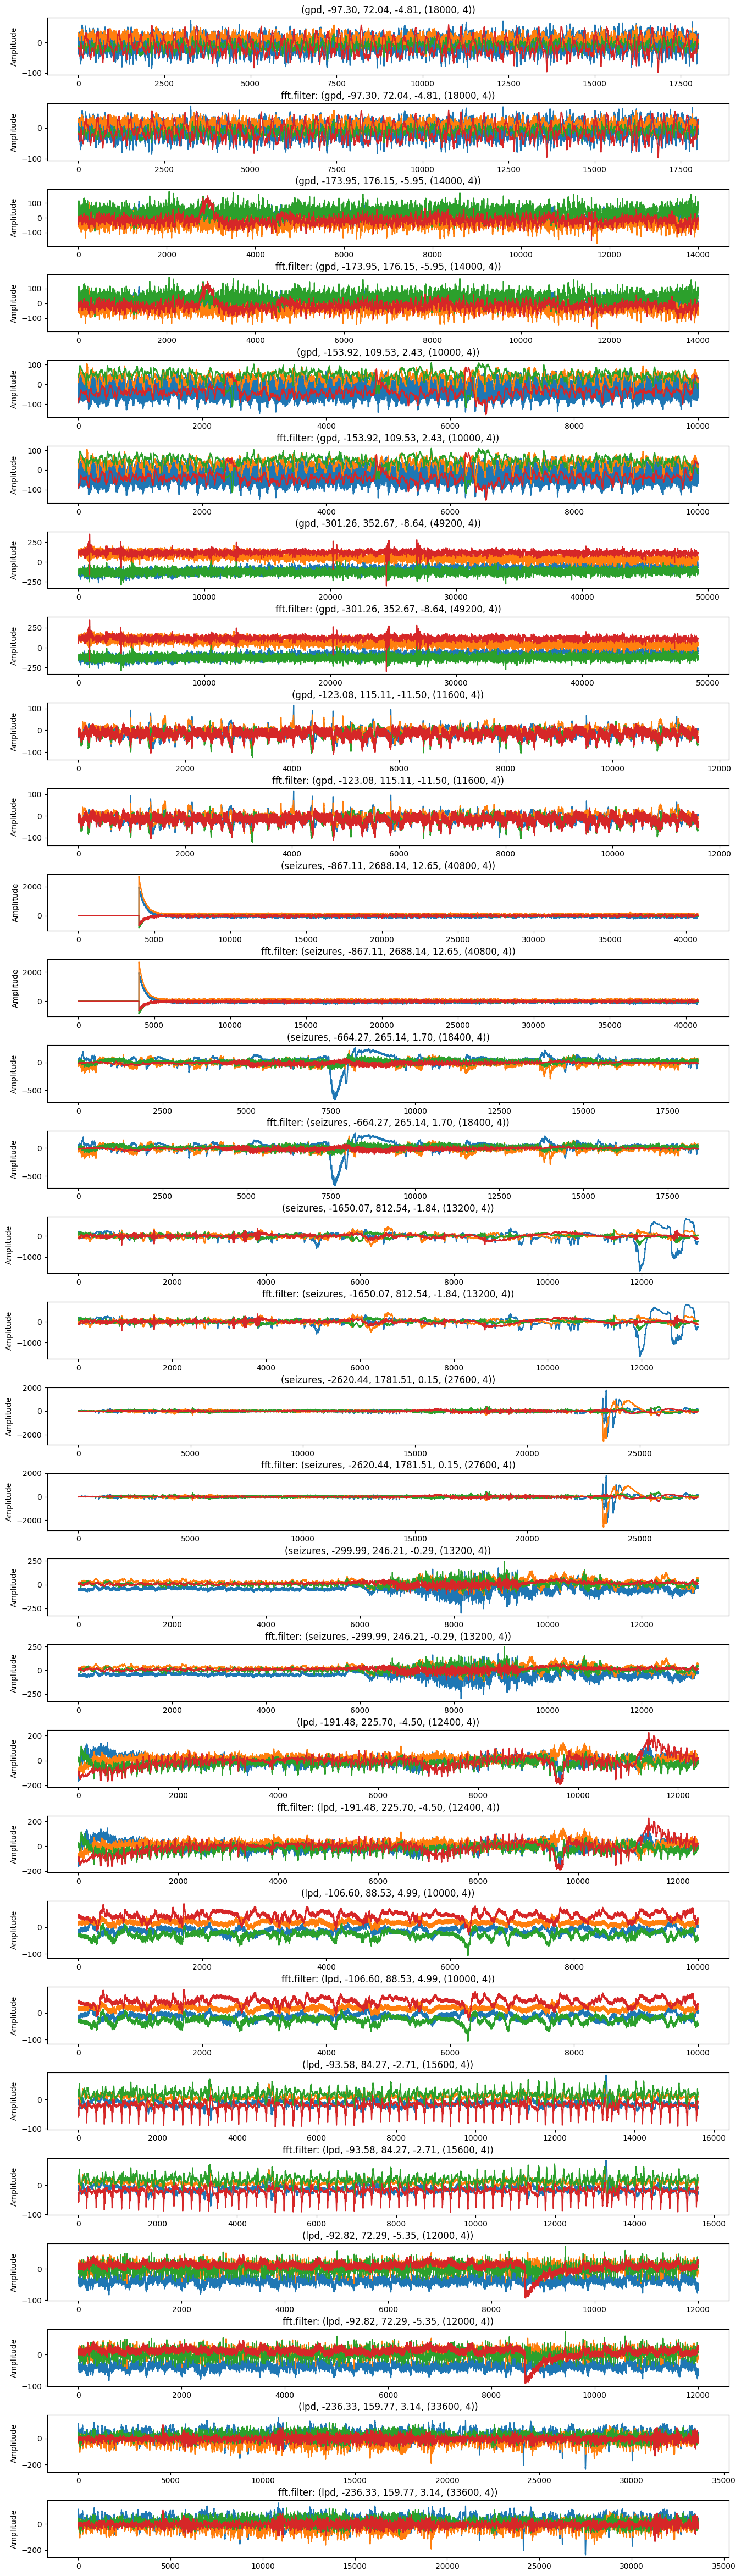

In [1943]:
import scipy.fft as fft

def resample_fn(data, target_sr, sr=200):
    num_samples = (data.shape[0] // sr)*target_sr
    resampled_data = signal.resample(data, num_samples)

    return resampled_data

def fft_filter(data, sr=200, limit=100):
    # Compute the FFT of the audio data
    yf = fft.fft(data)

    # Determine frequency bins (missing in the original snippet)
    xf = fft.fftfreq(len(data), 1 / sr)

    # yf[np.logical_and(np.abs(xf) > 8, np.abs(xf) < 14) ] = 0
    yf[np.abs(xf) > limit ] = 0

    return np.real(fft.ifft(yf))

# load_fn = lambda item: load_spectrogram(item)[..., 1:2]
transforms = {
    # 'five.channels': lambda data: data[:, 0],
    # 'butter.filter': lambda data: butter_lowpass_filter(data),
    # 'max.norm': norm_fn,
    # 'fft.real': lambda data: np.abs(fft.fft(data)),
    # 'fft.angle': lambda data: np.angle(fft.fft(data)),
    # 'inverse': inverse_fn,
    # 'mu.law': lambda data: quantize_data(data, 6)
    'fft.filter': fft_filter,

    # 'tanh': lambda data: np.tanh(data),
    # 'Minmax': lambda data: scale_fn(data),
}
title_fn = lambda _, item, data: f'({item.parts[1]}, {np.min(data):.2f}, {np.max(data):.2f}, {np.mean(data):.2f}, {data.shape})'
column_fn = lambda *x: 'Amplitude'

config = Props(
    eeg_signal=Props(
            groups=OrderedDict(
                LL=(['Fp1','F7','T3','T5'], ['F7','T3','T5','O1']),
                LP=(['Fp1','F3','C3','P3'], ['F3','C3','P3','O1']),
                RL=(['Fp2','F8','T4','T6'], ['F8','T4','T6','O2']),
                RP=(['Fp2','F4','C4','P4'], ['F4','C4','P4','O2']),
            ),
            sampling_rate=200,
            channels=16,
            duration=50,
            timesteps=10_000,
            
            # Target Sampling Rate
            resampling=200,
        ),
)
load_fn = eeg_loader(config)

_ = show_items(
    eeg_paths,
    # load_fn=lambda fp: resample_fn(load_fn(fp)[..., :4].mean(axis=-1), 20), title_fn=title_fn, column_fn=column_fn,
    load_fn=lambda fp: load_fn(fp)[..., :4], title_fn=title_fn, column_fn=column_fn,
    transforms=transforms,
    size=[16, 2], cols=1,
)

(16, 6, 140)
(16, 6, 78)
(16, 6, 90)
(16, 6, 143)
(16, 6, 214)
(16, 6, 97)
(16, 6, 121)
(16, 6, 261)


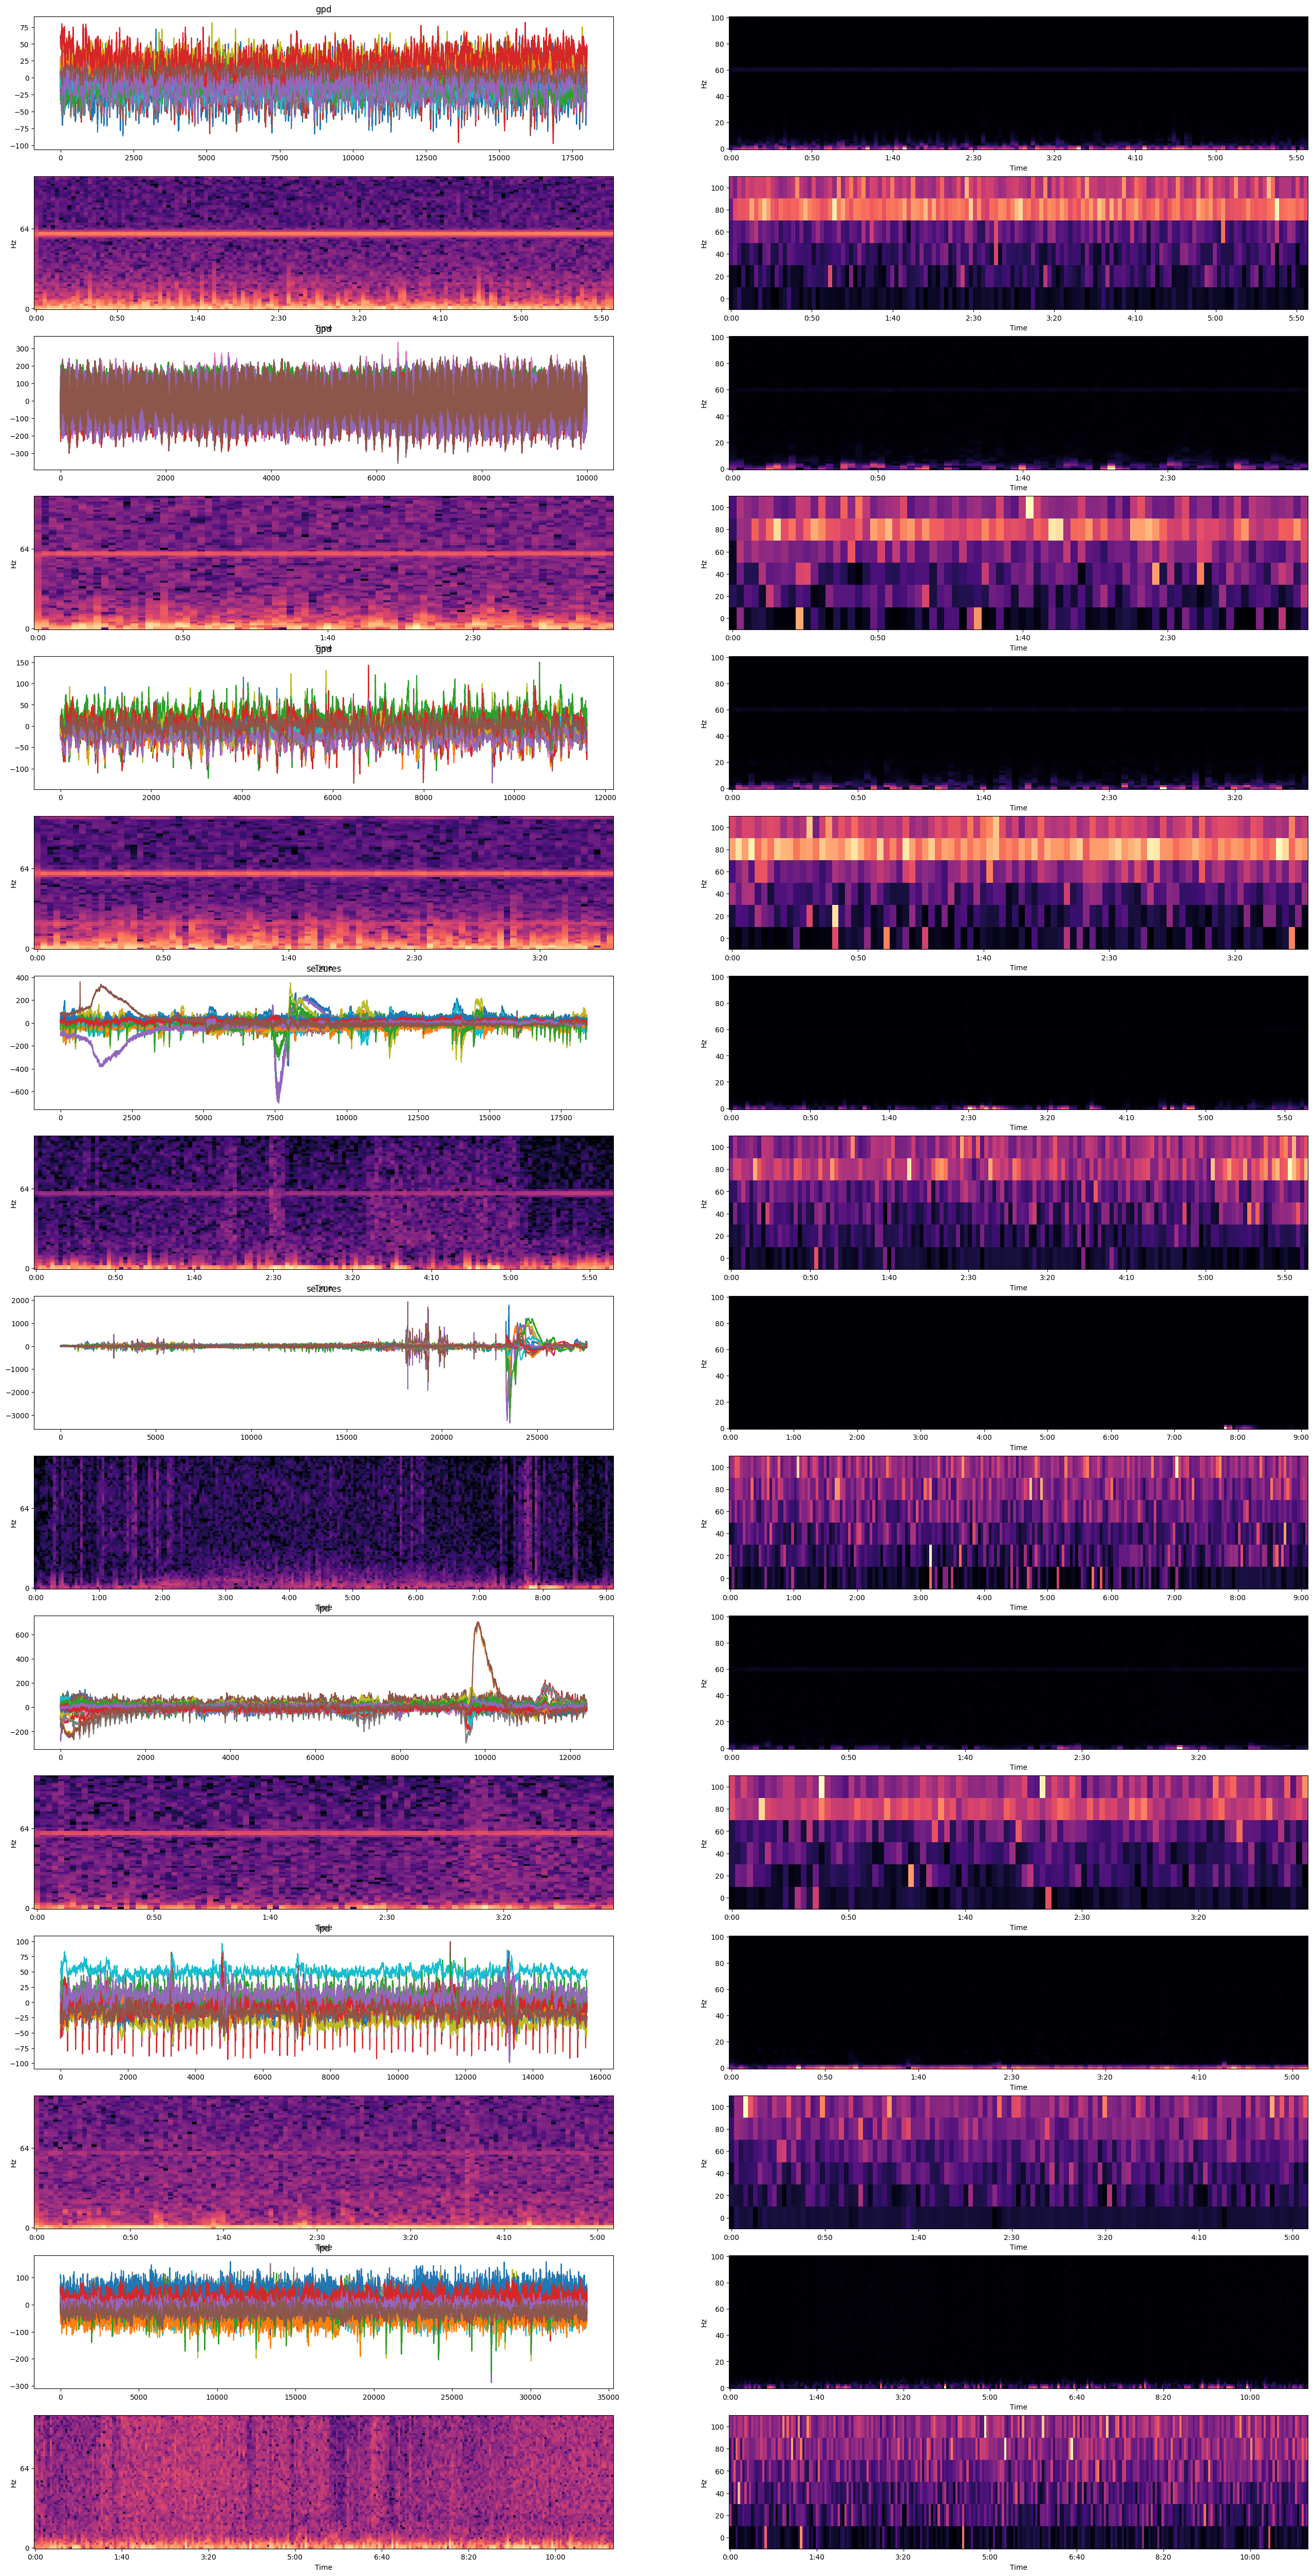

In [2125]:
import librosa

import numpy as np
import matplotlib.pyplot as plt


def show_items(items, load_fn, sr=200):
    sub_items = 4
    fig, axes = make_grid_plot(len(items)*sub_items, cols=2, size=[16, 4])
    n_fft = 128
    fid = 8

    for idx, item in enumerate(items):
        data = load_fn(item)


        D = np.abs(librosa.stft(data.T, n_fft=n_fft, hop_length=n_fft+1))
        P = librosa.power_to_db(D**2, ref=np.max)
        C = librosa.feature.spectral_contrast(S=D, sr=sr, fmin=4, n_bands=int(np.log2(sr//4)))
        print(C.shape)

        axes[sub_items*idx].plot(data)
        librosa.display.specshow(D[fid], sr=200, x_axis='time', y_axis='linear', ax=axes[sub_items*idx + 1])
        librosa.display.specshow(P[fid], sr=200, x_axis='time', y_axis='log', ax=axes[sub_items*idx + 2])
        librosa.display.specshow(C[fid], sr=200, x_axis='time', y_axis='linear', ax=axes[sub_items*idx + 3])
        axes[sub_items*idx].set_title(f'{item.parts[1]}')

show_items(eeg_paths[::2], load_fn, sr=200)

In [2052]:
18000//33

545